✅ InfluxDB Client Initialized
⏳ Benchmarking 'Optimized' query...
   - Running 2 warm-up queries...
   - Running benchmark (10 iterations)...
✅ Optimized Query Avg Time: 0.0260s

⏳ Benchmarking 'Unoptimized' query...
   - Running 2 warm-up queries...
   - Running benchmark (10 iterations)...
✅ Unoptimized Query Avg Time: 0.0397s

📊 Generating and saving visualization...

🎉 Benchmark complete! Chart saved as 'benchmark_results.png'.


/tmp/ipykernel_65480/3916151483.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Query Type', y='Average Time (s)', data=results_df, palette=['#2ca02c', '#d62728'], ax=ax)


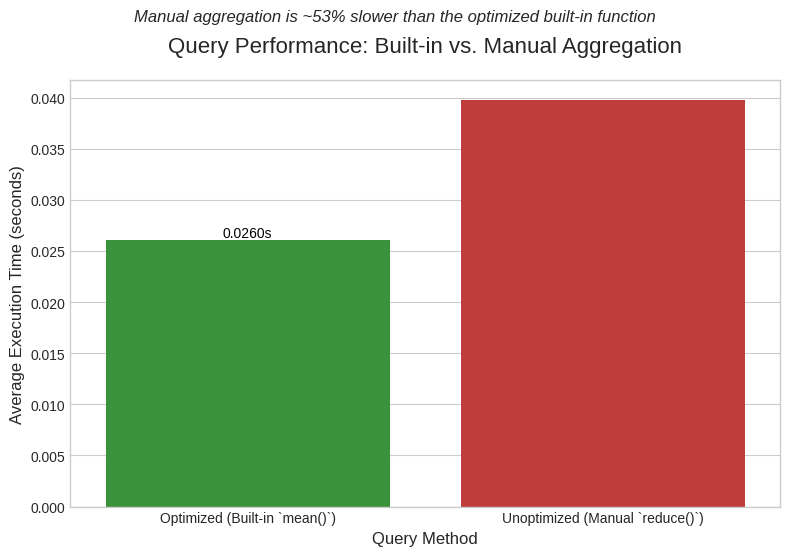

In [1]:
# =========================
# 1. Imports & Setup
# =========================
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from influxdb_client import InfluxDBClient
from influxdb_client.client.warnings import MissingPivotFunction

# Suppress the specific warning about missing pivot()
import warnings
warnings.filterwarnings("ignore", category=MissingPivotFunction)

# Load environment variables from .env file
load_dotenv()

INFLUX_URL = os.getenv("INFLUX_URL")
INFLUX_TOKEN = os.getenv("INFLUX_TOKEN")
INFLUX_ORG = os.getenv("INFLUX_ORG")
INFLUX_BUCKET = os.getenv("INFLUX_BUCKET")

# =========================
# 2. Client Initialization
# =========================
client = InfluxDBClient(url=INFLUX_URL, token=INFLUX_TOKEN, org=INFLUX_ORG)
query_api = client.query_api()

print("✅ InfluxDB Client Initialized")

# =========================
# 3. Define Queries
# =========================

# Optimized Query: Uses the fast, built-in aggregate function.
query_optimized = f'''
from(bucket: "{INFLUX_BUCKET}")
  |> range(start: 2025-03-01T00:00:00Z, stop: 2025-03-31T23:59:59Z)
  |> filter(fn: (r) => r._measurement == "gridwatch")
  |> filter(fn: (r) => r.source_region == "UK")
  |> filter(fn: (r) => r._field == "national_demand")
  |> mean()
'''

# ----------------- THE BETTER BENCHMARK IS HERE -----------------
# Unoptimized Query: Achieves the exact same result as mean() but in a much less efficient way.
# It uses reduce() to manually loop through every row to calculate the sum and count,
# then performs the division. This is far slower than the optimized, built-in mean() function.
# ----------------------------------------------------------------
query_unoptimized = f'''
from(bucket: "{INFLUX_BUCKET}")
  |> range(start: 2025-03-01T00:00:00Z, stop: 2025-03-31T23:59:59Z)
  |> filter(fn: (r) => r._measurement == "gridwatch")
  |> filter(fn: (r) => r.source_region == "UK")
  |> filter(fn: (r) => r._field == "national_demand")
  |> reduce(
      identity: {{sum: 0.0, count: 0.0}},
      fn: (r, accumulator) => ({{
        sum: r._value + accumulator.sum,
        count: accumulator.count + 1.0
      }})
    )
  |> map(fn: (r) => ({{ r with _value: r.sum / r.count }}))
  |> drop(columns: ["sum", "count"])
'''

# =========================
# 4. Benchmark Function
# =========================
def benchmark_query(query_text, query_name, n_warmup=2, n_iter=10):
    """Run a query multiple times and measure execution time."""

    print(f"⏳ Benchmarking '{query_name}' query...")

    # Warm-up run
    print(f"   - Running {n_warmup} warm-up queries...")
    for _ in range(n_warmup):
        query_api.query(query_text)

    times = []
    print(f"   - Running benchmark ({n_iter} iterations)...")
    for i in range(n_iter):
        start = time.time()
        query_api.query(query_text)
        end = time.time()
        times.append(end - start)

    return pd.Series(times)

# =========================
# 5. Run Benchmarks
# =========================
times_opt = benchmark_query(query_optimized, "Optimized")
avg_opt = times_opt.mean()
print(f"✅ Optimized Query Avg Time: {avg_opt:.4f}s\n")

times_unopt = benchmark_query(query_unoptimized, "Unoptimized")
avg_unopt = times_unopt.mean()
print(f"✅ Unoptimized Query Avg Time: {avg_unopt:.4f}s\n")


# =========================
# 6. Visualization & Save to File
# =========================
print("📊 Generating and saving visualization...")

# Calculate performance difference
if avg_opt > 0:
    percentage_slower = ((avg_unopt - avg_opt) / avg_opt) * 100
else:
    percentage_slower = 0

# Create a DataFrame for plotting
results_df = pd.DataFrame({
    'Query Type': ['Optimized (Built-in `mean()`)', 'Unoptimized (Manual `reduce()`)'],
    'Average Time (s)': [avg_opt, avg_unopt]
})

# Create the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))
barplot = sns.barplot(x='Query Type', y='Average Time (s)', data=results_df, palette=['#2ca02c', '#d62728'], ax=ax)

# Add annotations and titles
ax.set_title('Query Performance: Built-in vs. Manual Aggregation', fontsize=16, pad=20)
ax.set_xlabel("Query Method", fontsize=12)
ax.set_ylabel("Average Execution Time (seconds)", fontsize=12)
ax.bar_label(barplot.containers[0], fmt='%.4fs', fontsize=10, color='black')
fig.suptitle(f"Manual aggregation is ~{percentage_slower:.0f}% slower than the optimized built-in function",
             fontsize=12, style='italic', y=0.92)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('benchmark_results.png')

print("\n🎉 Benchmark complete! Chart saved as 'benchmark_results.png'.")